### Описание задач
ЛЕГЕНДА: 
Требуется произвести глубокий анализ поведения пользователей над мобильной игрой Quiz Freeze. Для проекта используются таблицы event и purchase, хранящие данные о действиях пользователей в игре Quiz Freeze.

ЦЕЛЬ: 
Исследовать поведение пользователей в обновлённом приложении.

Гипотеза 1: 
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Гипотеза 2: 
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

Гипотеза 3: 
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

ЗАДАЧИ: 

1.Определить, насколько обучение сокращает время прохождения этапов игры.

2.Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

3.Определить, насколько прозрачен процесс взаимодействия с игрой.

Важно! Задание выполняется на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).

### Ход проверки

Импортируем нужные библиотеки
Получаем данные из базы данных

In [1]:
# Импортируем нужные библиотеки
 
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Получаем данные из базы данных
Events = pd.read_csv('C:\SKILLLB\M44PROJECT3\Events.csv', sep=',')
purchase = pd.read_csv('C:\SKILLLB\M44PROJECT3\purchase.csv', sep=',')

# #создаем копии
events_df = Events.copy()
purchase_df = purchase.copy()
print(events_df.info)
print(purchase_df.info)
# print(events_df.describe())
# print(events_df.head(-10))

<bound method DataFrame.info of             id       event_type selected_level           start_time  \
0        28903     registration            NaN  2016-05-11T23:40:55   
1        28904     registration            NaN  2016-05-11T23:49:58   
2        28905     registration            NaN  2016-05-12T00:53:07   
3        28906   tutorial_start            NaN  2016-05-12T01:32:20   
4        28907  tutorial_finish            NaN  2016-05-12T01:34:53   
...        ...              ...            ...                  ...   
252329  281232     level_choice           hard  2020-07-02T10:02:15   
252330  281233     level_choice         medium  2020-07-02T11:38:52   
252331  281234      pack_choice            NaN  2020-07-02T11:42:14   
252332  281235   tutorial_start            NaN  2020-07-02T13:32:58   
252333  281236  tutorial_finish            NaN  2020-07-02T13:36:36   

        tutorial_id  user_id  
0               NaN    12583  
1               NaN    12584  
2               NaN   

Фильтруем пользователей зарегистрированных в 2018 г

In [2]:
# Фильтруем пользователей зарегистрированных в 2018 г
mask1 = events_df['start_time'] >= '2018-01-01'
mask2 = events_df['start_time'] < '2019-01-01'
mask3 = events_df['event_type'] == 'registration'

# Оставляем в таблице только пользователей зарегистрированных в 2018 г.
users_2018 = events_df[mask1 & mask2 & mask3]['user_id'].to_list()
events_df = events_df[events_df['user_id'].isin(users_2018)]
purchase_df = purchase[purchase['user_id'].isin(users_2018)]

# events_df.info()

Произведем преобразование типов 

In [3]:
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'])

c:\temp1\ipykernel_6300\4128140302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'])


In [4]:
# Перед объединением датафреймов, переименуем колонки
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

# Создадим новый столбец момента оплаты
purchase_df['event_type'] = 'purchase'

# Сделаем объединенный датафрейм из событий и оплат
total_events_df = pd.concat([events_df, purchase_df], ignore_index = True).sort_values(by = 'start_time')

# Произведем преобразование типа
total_events_df['start_time'] = pd.to_datetime(total_events_df['start_time'])
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

display(total_events_df.head())

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


Гипотеза 1: Обучение влияет на скорость прохождения других этапов игры

In [5]:
#cоздаем сводную таблицу по минимальному времени начала этапа для подсчета разницы
pivot_df=total_events_df.pivot_table(values='start_time', index='user_id', columns='event_type', aggfunc='min') 

In [6]:
# время от регистрации до начала обучения
pivot_df['delta_tutorial_start'] = (pivot_df['tutorial_start'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время от регистрации до конца обучения
pivot_df['delta_tutorial_finish'] = (pivot_df['tutorial_finish'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время на всю последовательность
pivot_df['delta_all_time'] = (pivot_df['purchase'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время от выбора сложности до окончания обучения
pivot_df['delta_level_choice']=(pivot_df['level_choice']-pivot_df['tutorial_finish'])/pd.Timedelta('1 hour') 
# время от выбора сложности до покупки
pivot_df['delta_pach_choice']=(pivot_df['pack_choice']-pivot_df['level_choice'])/pd.Timedelta('1 hour')
# время на оплату 
pivot_df['delta_purchase']=(pivot_df['purchase']-pivot_df['pack_choice'])/pd.Timedelta('1 hour') 

In [7]:
#обозначим тех, кто начал обучение
users_with_started_tutorial = set(events_df[events_df['event_type'] == 'tutorial_start']['user_id'])
all_users = set(events_df['user_id'])
#обозначим тех, кто обучение не проходил
not_start_tutorial = all_users.difference(users_with_started_tutorial)
#обозначим тех, кто прошел обучение
tutorial_finished_users = set(total_events_df[total_events_df["event_type"] == "tutorial_finish"]['user_id']) 

In [8]:
#сбросим индексы
pivot_df = pivot_df.reset_index()

In [9]:
#создадим функцию, которая будет определять группу пользователя
def get_tutorial_status(user_id):
    if user_id in tutorial_finished_users:
        return 'FINISHED'
    elif user_id in not_start_tutorial:
        return 'NOT_START'
    else:
        return 'NO_DATA'
    
pivot_df['group']=pivot_df['user_id'].apply(get_tutorial_status)

c:\temp1\ipykernel_6300\2978231261.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bar_data = pivot_df.groupby(by='group', as_index=False)['delta_all_time','delta_purchase','delta_tutorial_start', 'delta_tutorial_finish', 'delta_level_choice', 'delta_pach_choice'].mean()


group,group,FINISHED,NOT_START,NO_DATA
0,delta_all_time,96.500902,105.10053,101.548115
1,delta_purchase,89.2999,100.825997,93.246363
2,delta_tutorial_start,4.518038,NaN,5.41747
3,delta_tutorial_finish,4.721878,NaN,NaN
4,delta_level_choice,2.329711,NaN,NaN
5,delta_pach_choice,0.088374,0.089951,0.084804


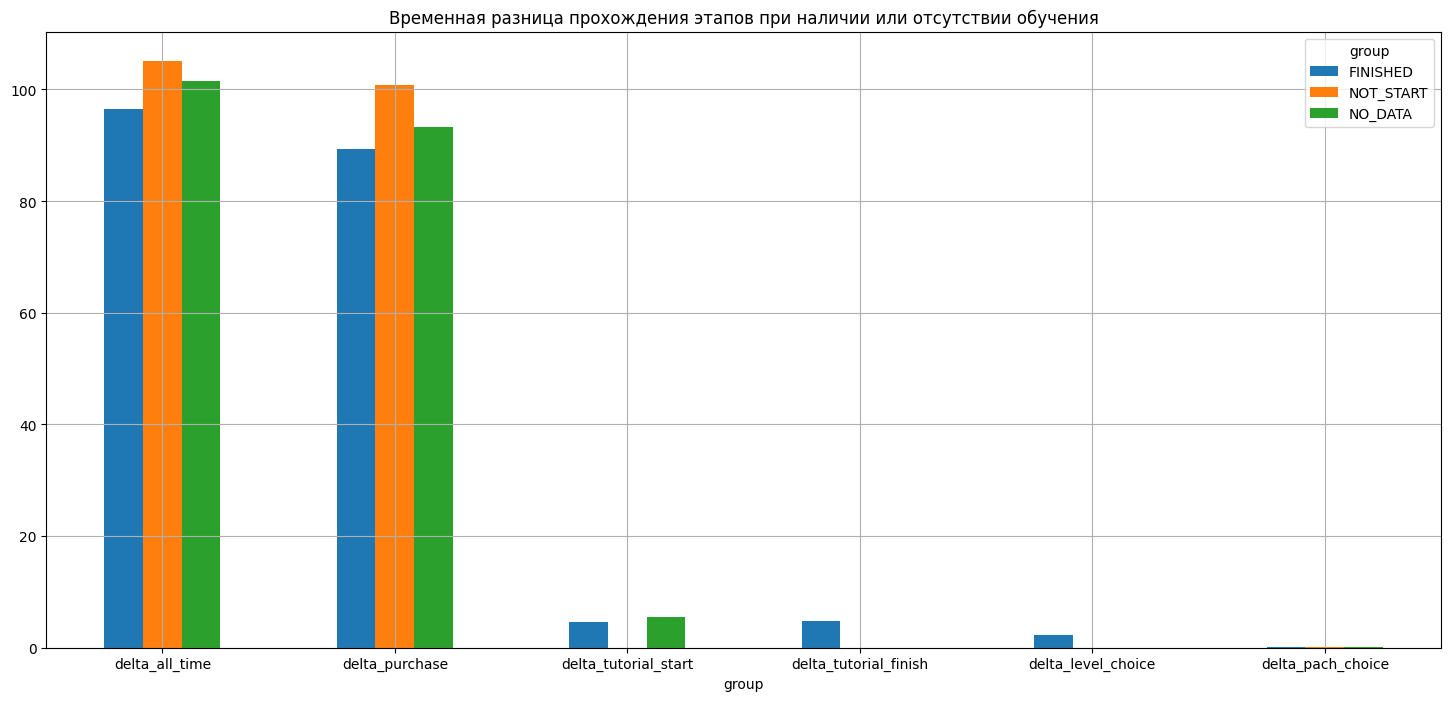

In [10]:
#создаем датафрейм для визуализации данных
bar_data = pivot_df.groupby(by='group', as_index=False)['delta_all_time','delta_purchase','delta_tutorial_start', 'delta_tutorial_finish', 'delta_level_choice', 'delta_pach_choice'].mean()
bar_data = bar_data.transpose()
bar_data.columns = bar_data.iloc[0]
bar_data = bar_data.iloc[1:]
bar_data.index.rename('group', inplace=True)
bar_data = bar_data.reset_index()
#визуализируем данные
bar_data.plot(
    kind='bar',
    grid=True,
    figsize=(18, 8),
    x='group',
    rot=0,
    fontsize=10,
    title='Временная разница прохождения этапов при наличии или отсутствии обучения'
    ) ;
bar_data

Вывод: 
Из столбчатой диаграммы наглядно видно, что время прохождения игры у "обученных" людей ниже. 
Для детального анализа следует перейти к изучению числовых показателей.
Этап от регистрации пользователя до покупки платных вопросов составляет 101 час. Если пользователь прошел обучение, то время такого же пути сокращается до 96,5 часов в среднем, а если обучение проигнорировано, то увеличивается до 105 часов (+8%). Последняя группа пользователей, которая не закончила обучение проходит все этапы за 101 час.  
Переход от уровня сложности до выбора пакета вопросов у всех групп примерно одинаковый, составляет чуть больше 5 минут. Пользователи, которые пренебрегли обучением, теряют на этапе от выбора вопросов до оплаты больше всего времени на 12 часов больше по сравнению с пользователями, которые прошли обучение.  

Гипотеза 2: Повторное прохождение обучения положительно влияет на оплату

In [11]:
#Разделим пользователей на группы по количеству стартов обучения
tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
start_group = tutorial_start_df.groupby(['user_id'])['event_type'].count().sort_values(ascending=False)
user_start_group = tutorial_start_df['user_id'].unique()
start_group_count = start_group.value_counts().sort_index()

#Выделим пользователей из группы начавших обучение и перешедших в клиенты
purchase_start = total_events_df[(total_events_df['event_type'] == 'purchase') & (total_events_df['user_id'].isin(user_start_group))]['user_id']

display(start_group_count)
display(purchase_start)

1    9103
2    1589
3     427
4     221
5     109
6     116
7      94
8      86
9     113
Name: event_type, dtype: int64

125      27845
178      27865
449      27911
467      27910
472      27940
         ...  
68554    47498
68555    47647
68556    47554
68557    47742
68558    47732
Name: user_id, Length: 1578, dtype: int64

In [12]:
#Разделим пользователей на группы по количеству завершений обучения
tutorial_finish_df = total_events_df[total_events_df['event_type'] == 'tutorial_finish']
finish_group = tutorial_finish_df.groupby(['user_id'])['event_type'].count().sort_values(ascending=False)
user_finish_group = tutorial_finish_df['user_id'].unique()
finish_group_count = finish_group.value_counts().sort_index()

#Выделим пользователей из группы завершивших обучение и перешедших в клиенты
purchase_finish = total_events_df[(total_events_df['event_type'] == 'purchase') & (total_events_df['user_id'].isin(user_finish_group))]['user_id']

display(finish_group_count)
display(purchase_finish)

1    8015
2    1321
3     345
4     178
5     117
6     101
7      97
8      54
9      22
Name: event_type, dtype: int64

125      27845
467      27910
472      27940
538      27981
544      27969
         ...  
68554    47498
68555    47647
68556    47554
68557    47742
68558    47732
Name: user_id, Length: 1447, dtype: int64

In [13]:
#Создаем дубликат для дальнейших расчетов
total_events_copy = total_events_df.copy()

In [14]:
#Создаем функцию для подсчета завершений обучения
def count_finish_tutorial(row):
    if row.event_type == 'tutorial_finish':
        return 1
#Создаем функцию для завершений обучения 
total_events_copy['count_tutorial_finish'] = total_events_copy.apply(count_finish_tutorial, axis=1)


In [15]:
#Создаем функцию для подсчета клиентов
def count_client(x):
    if x['event_type']=='purchase':
        return 1
#Добавляем счетчик клиентов
total_events_copy['count_client'] = total_events_copy.apply(count_client, axis=1)    

In [16]:
#Создаем функцию для подсчета пользователей
def count_users(x):
    if x['event_type']=='registration':
        return 1
#Добавляем счетчик пользователей
total_events_copy['count_users'] = total_events_copy.apply(count_users, axis=1) 

In [17]:
#Создаем новый датафрейм
group_df = total_events_copy.groupby(by='user_id').sum()
group_df['count_users'] = 1
#Агрегируем данные по количеству завершений обучений
group_final_finish = group_df.groupby(by='count_tutorial_finish').sum() 
group_final_finish = group_final_finish.drop(['event_id', 'tutorial_id', 'purchase_id'], axis=1)
#Считаем конверсию
group_final_finish['conversion']=(group_final_finish['count_client']*100/group_final_finish['count_users']).round(2) 
group_final_finish

c:\temp1\ipykernel_6300\271257270.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df = total_events_copy.groupby(by='user_id').sum()


,amount,count_client,count_users,conversion
count_tutorial_finish,,,,
0.0,16575.0,153.0,9676,1.58
1.0,126025.0,1143.0,8015,14.26
2.0,20625.0,182.0,1321,13.78
3.0,5475.0,44.0,345,12.75
4.0,1950.0,19.0,178,10.67
5.0,1950.0,19.0,117,16.24
6.0,1625.0,15.0,101,14.85
7.0,1750.0,15.0,97,15.46
8.0,800.0,6.0,54,11.11


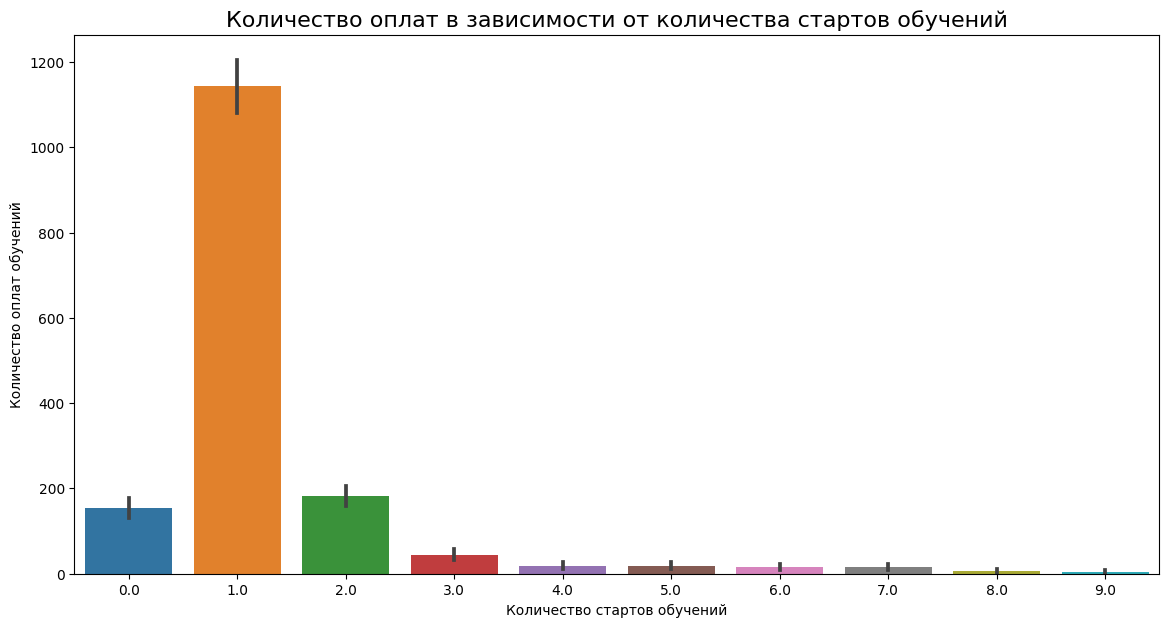

In [18]:
#визуализируем данные
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,7))
barplot1 = sns.barplot(
    data = group_df,
    x = 'count_tutorial_finish',
    y = 'amount',
    estimator = 'count_nonzero'
)
barplot1.set_title('Количество оплат в зависимости от количества стартов обучений', fontsize=16)
barplot1.set_xlabel('Количество стартов обучений', fontsize=10)
barplot1.set_ylabel('Количество оплат обучений', fontsize=10)
plt.show()

Выводы:
В процессе анализа было выявлено 10 групп (0 - не закончившие обучение, 1-9 - по количеству окончаний обучения соответственно). Вероятность покупки возрастает на 10-18%, если обучение было пройдено, но показатель конверсии очень разрозненный по группам. А если обучение не начиналось, то только 1,58% пользователей совершают покупку.

Зависимости между вероятностью оплаты и количеством обучений не наблюдается. Однако факт окончания или начала обучения значительно повышает вероятность оплаты.

Гипотеза 3: Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение

In [19]:
#Создаем датасет с событием level_choice
level_choice_df = events_df[events_df['event_type'] == 'level_choice'][['user_id','start_time']]
level_choice_df = level_choice_df.rename(columns= {'start_time':'level_choice_time'})
level_choice_df['level_choice_time']=pd.to_datetime(level_choice_df['level_choice_time']) 
#Создаем датасет с временем события start_time и level_choice_time 
tutorial_start_level_choise_df = tutorial_start_df.merge(level_choice_df, on='user_id', how='inner')
tutorial_start_level_choise_df['time_delta'] = \
    tutorial_start_level_choise_df['start_time'] - tutorial_start_level_choise_df['level_choice_time']

print(tutorial_start_level_choise_df)

       event_id      event_type selected_level          start_time  \
0       80316.0  tutorial_start            NaN 2018-01-01 15:00:51   
1       80323.0  tutorial_start            NaN 2018-01-01 19:11:36   
2       80337.0  tutorial_start            NaN 2018-01-02 02:07:07   
3       80338.0  tutorial_start            NaN 2018-01-02 03:03:44   
4       80349.0  tutorial_start            NaN 2018-01-02 07:08:00   
...         ...             ...            ...                 ...   
12681  147236.0  tutorial_start            NaN 2018-12-31 07:14:38   
12682  147242.0  tutorial_start            NaN 2018-12-31 10:21:11   
12683  147253.0  tutorial_start            NaN 2018-12-31 20:54:56   
12684  147260.0  tutorial_start            NaN 2019-01-01 00:08:14   
12685  147262.0  tutorial_start            NaN 2019-01-01 03:26:18   

       tutorial_id  user_id  purchase_id  amount   level_choice_time  \
0          31506.0    27835          NaN     NaN 2018-01-01 20:37:22   
1          3150

In [20]:
#Посчитаем разницу между временем выбора уровня и временем начала обучения(time_delta)
#Если разница отрицаельная, значит обучение началось после выбора уровня
#Пользователи, прошедшие обучение после выбора уровня сложности   
users_tutorial_after_level_choice = tutorial_start_level_choise_df[tutorial_start_level_choise_df['time_delta']>'1 seconds']['user_id'].nunique()
print('')
print('Пользователи, прошедшие обучение после выбора уровня сложности', users_tutorial_after_level_choice) 

users_tutorial_before_level_choice = tutorial_start_level_choise_df[ tutorial_start_level_choise_df\
                                                                    ['time_delta']<pd.Timedelta(0)]['user_id'].nunique()
#Пользователи, прошедшие обучение до выбора уровня сложности
print('Пользователи, прошедшие обучение до выбора уровня сложности', users_tutorial_before_level_choice)


Пользователи, прошедшие обучение после выбора уровня сложности 1386
Пользователи, прошедшие обучение до выбора уровня сложности 8244


In [21]:
#Посчитаем соотношение прошедших обучение после выбора уровня сложности к прошедшим обучение до выбора уровня сложности
percent_users_tutorial_after_level_choice = users_tutorial_after_level_choice / users_tutorial_before_level_choice*100
print('Соотношение прошедших обучение после выбора уровня сложности к прошедшим обучение до выбора уровня сложности', percent_users_tutorial_after_level_choice)

Соотношение прошедших обучение после выбора уровня сложности к прошедшим обучение до выбора уровня сложности 16.812227074235807


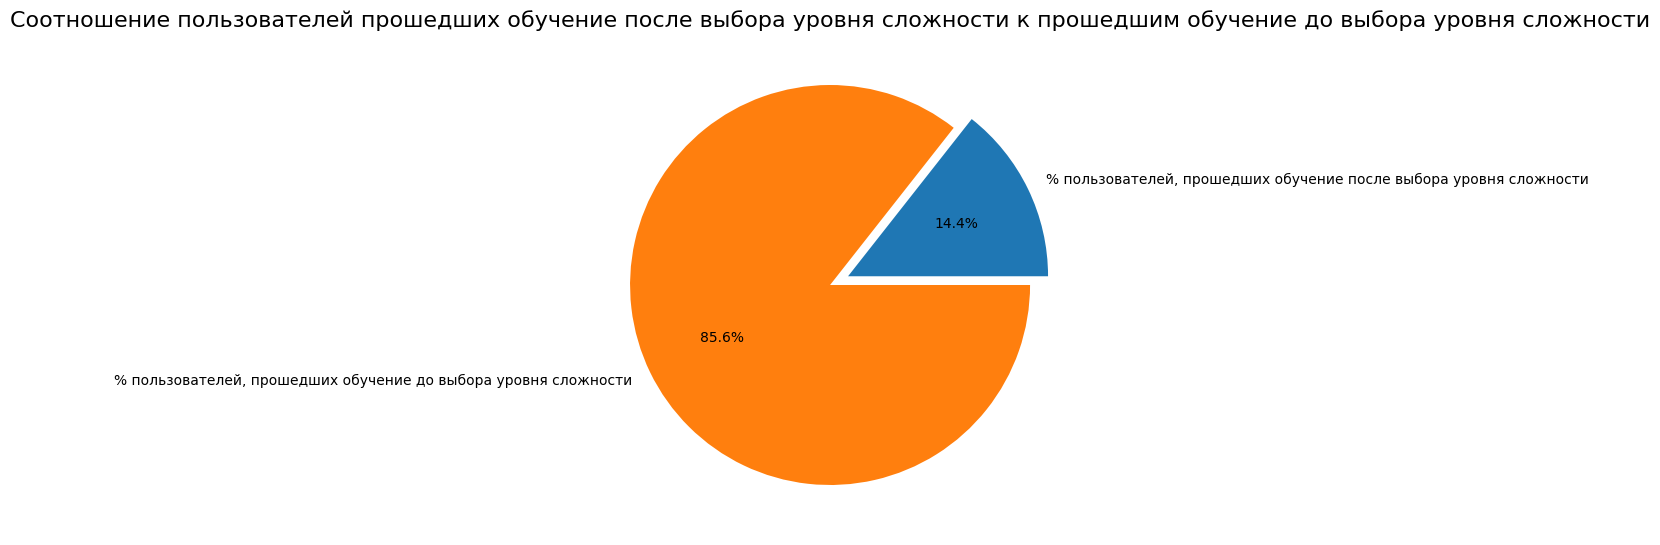

In [22]:
tutorial_start_level_choise_df = [users_tutorial_after_level_choice, users_tutorial_before_level_choice]
labels = ['% пользователей, прошедших обучение после выбора уровня сложности', '% пользователей, прошедших обучение до выбора уровня сложности']
fig = plt.figure(figsize=(5,5))
axes = fig.add_axes([0,0,1,1])
axes.pie(tutorial_start_level_choise_df, labels=labels, autopct='%1.1f%%', explode = [0.1, 0])
axes.set_title('Соотношение пользователей прошедших обучение после выбора уровня сложности к прошедшим обучение до выбора уровня сложности', fontsize=16)
plt.show()

Вывод: В процессе анализа был произведен расчет пользователей, прошедшие обучение после выбора уровня сложности (1386 человек) и пользователей, прошедшие обучение до выбора уровня сложности (8244 человека). В процентном соотношении это составляет 16.8%. Соответственно пользователи начинают обучение после того, как выбрали уровень сложности тренировок, не часто, а значит приложение довольно интуитивно и не вызывает особых сложностей у пользователей.

Общие выводы по проекту

1. Согласно расчетам время прохождения игры у "обученных" людей ниже. 
2. Зависимости между вероятностью оплаты и количеством обучений не выявлено. Однако факт окончания или начала обучения значительно повышает вероятность оплаты.
3. Соотношение пользователей, прошедших обучение после выбора уровня сложности (1386 человек) и пользователей, прошедших обучение до выбора уровня сложности составляет 16.8%. Соответственно пользователи начинают обучение после того, как выбрали уровень сложности тренировок, не часто, а значит приложение довольно интуитивно и не вызывает особых сложностей у пользователей.